# Alignment with DTW

In [18]:
# Code source: Stefan Balke
# License: ISC
# sphinx_gallery_thumbnail_number = 4

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import librosa
from IPython.display import Audio

## 1. Load Audio Files

First, we'll load our reference recording and the "live" recording (which we'll simulate as being played in real-time).
We'll use guitar recordings at different tempos from the audio directory.

In [19]:
audio_reference = "audio/Acordai-80.mp3"
audio_live = "audio/Acordai-90.mp3"

# Load the reference audio file
y_reference, sr = librosa.load(audio_reference, sr=None)
# Load the live audio file
y_live, sr = librosa.load(audio_live, sr=None)

Reference duration: 16.47s
Live duration: 21.78s


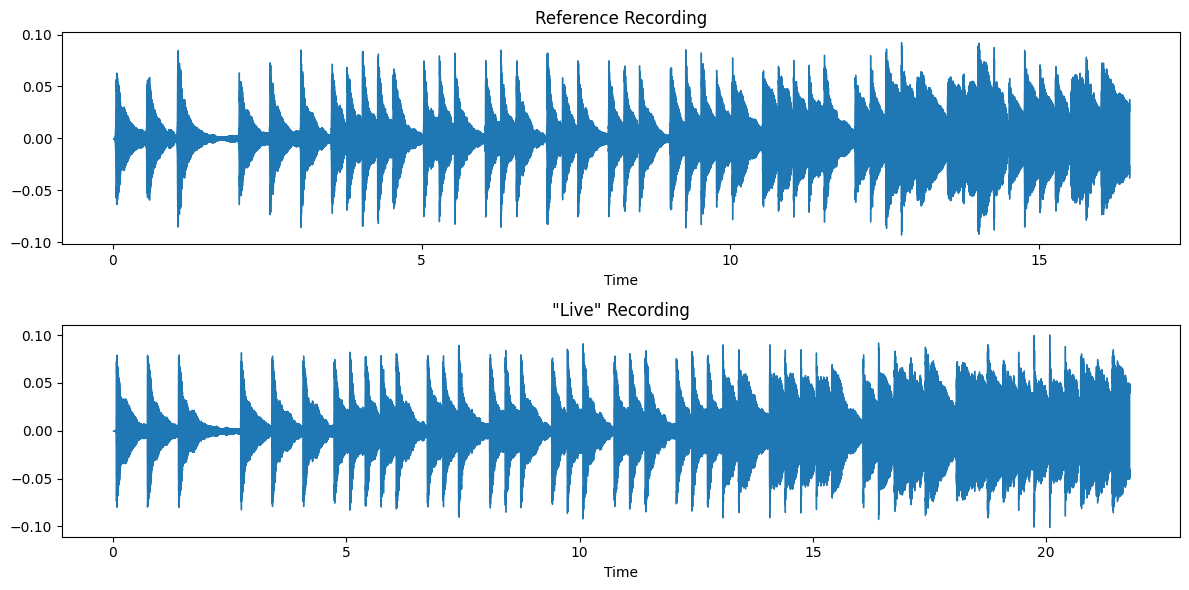

In [20]:
# Display the waveforms
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
librosa.display.waveshow(y_reference, sr=sr)
plt.title('Reference Recording')

plt.subplot(2, 1, 2)
librosa.display.waveshow(y_live, sr=sr)
plt.title('"Live" Recording')
plt.tight_layout()

print(f"Reference duration: {librosa.get_duration(y=y_reference, sr=sr):.2f}s")
print(f"Live duration: {librosa.get_duration(y=y_live, sr=sr):.2f}s")

[Text(0.5, 1.0, 'Versión 2')]

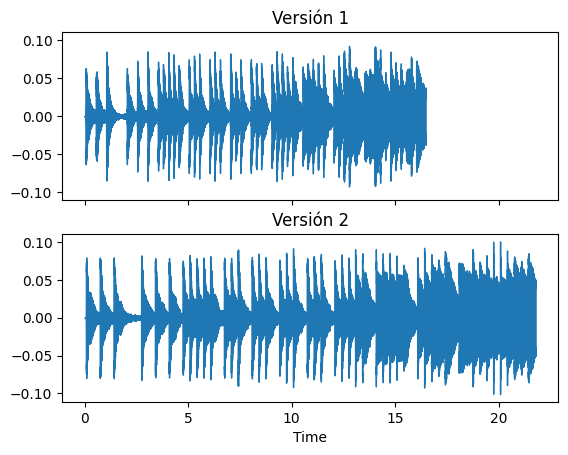

In [32]:

fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True)
librosa.display.waveshow(y_reference, sr=sr, ax=ax[0])
ax[0].set(title='Versión 1')
ax[0].label_outer()

librosa.display.waveshow(y_live, sr=sr, ax=ax[1])
ax[1].set(title='Versión 2')

### Listen to the recordings

In [21]:
# Listen to reference
print("Reference recording:")
Audio(data=y_reference, rate=sr)

Reference recording:


In [22]:
# Listen to "live"
print("'Live' recording:")
Audio(data=y_live, rate=sr)

'Live' recording:


## 2. Pre-compute Reference Features

We'll extract chroma features from the reference recording, which capture harmonic content while being relatively robust to timbre differences.

In [26]:
hop_length = 512

In [28]:

def extract_chroma(audio, sampling_rate, hop_length):
    # Extract chroma features from reference recording
    chroma_reference = librosa.feature.chroma_cqt(y=audio, sr=sampling_rate, 
                                                hop_length=hop_length,
                                                n_chroma=12,
                                                bins_per_octave=36
                                                )
    return chroma_reference

def normalize_chroma(chroma):
    # Crear una matriz de ceros del mismo tamaño que chroma
    normalized = np.zeros_like(chroma)
    
    # Para cada columna (instante temporal)
    for i in range(chroma.shape[1]):
        # Obtener el índice del pitch class con mayor valor
        max_index = np.argmax(chroma[:, i])
        # Asignar el valor original en esa posición
        normalized[max_index, i] = chroma[max_index, i]
    
    return normalized

def visualize_chroma(chroma, title='Chroma features'):
    # Visualize reference chroma
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(chroma, x_axis='time', y_axis='chroma',
                            hop_length=hop_length, sr=sr)
    plt.colorbar(label='Normalized amplitude')
    plt.title(title)
    plt.tight_layout()

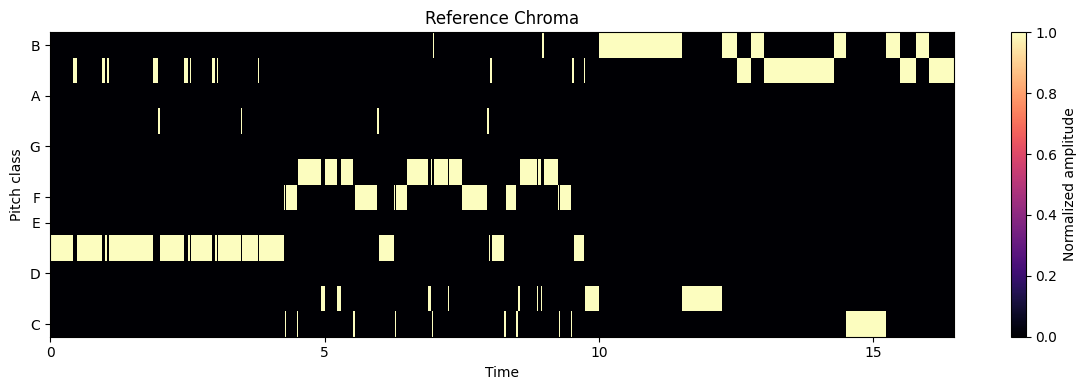

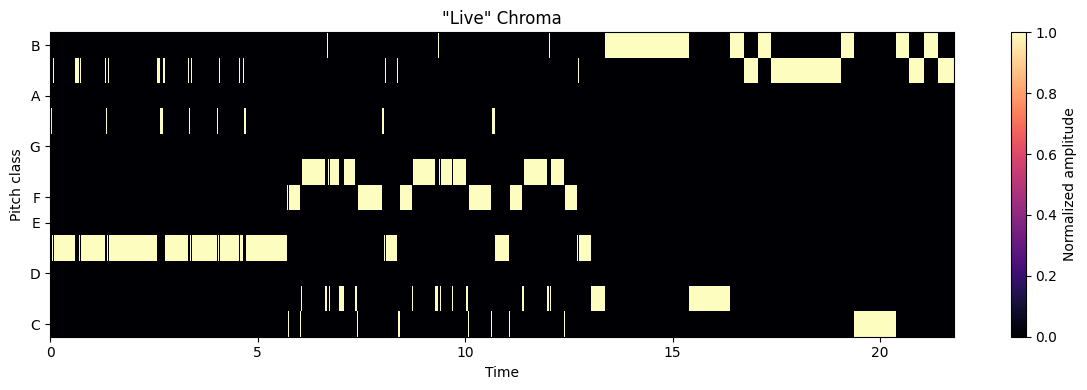

In [30]:
chroma_reference = extract_chroma(y_reference, sr, hop_length)
chroma_live = extract_chroma(y_live, sr, hop_length)
chroma_reference_normalized = normalize_chroma(chroma_reference)
chroma_live_normalized = normalize_chroma(chroma_live)
visualize_chroma(chroma_reference_normalized, title='Reference Chroma')
visualize_chroma(chroma_live_normalized, title='"Live" Chroma')

In [34]:
D, wp = librosa.sequence.dtw(X=chroma_reference_normalized, Y=chroma_live_normalized, metric='cosine')
wp_s = librosa.frames_to_time(wp, sr=sr, hop_length=hop_length)

In [36]:
print(f"DTW distance: {D[-1, -1]:.2f}")

DTW distance: 46.00


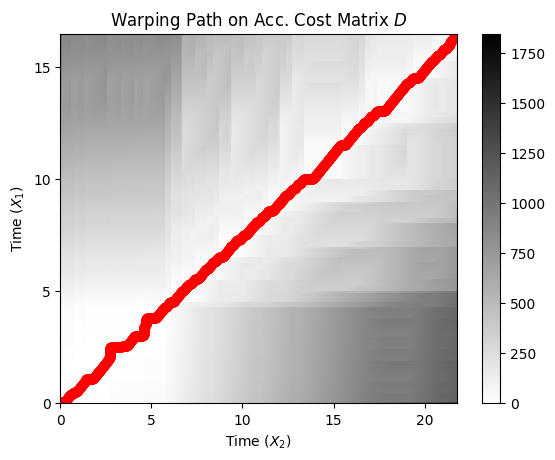

In [35]:
fig, ax = plt.subplots()
img = librosa.display.specshow(D, x_axis='time', y_axis='time', sr=sr,
                               cmap='gray_r', hop_length=hop_length, ax=ax)
ax.plot(wp_s[:, 1], wp_s[:, 0], marker='o', color='r')
ax.set(title='Warping Path on Acc. Cost Matrix $D$',
       xlabel='Time $(X_2)$', ylabel='Time $(X_1)$')
fig.colorbar(img, ax=ax)